# Wstępne przetwarzanie danych — projekt
Notebook realizuje zadanie z przetwarzania danych dla zbioru *Medical Cost Personal Dataset* (https://www.kaggle.com/datasets/mirichoi0218/insurance).

## Zakres:
1. Odczyt zbioru, identyfikacja danych błędnych i brakujących
2. Wygenerowanie braków danych (min. 10%)
3. Analiza i ekstrakcja cech (łączenie, nowe kolumny)
4. Uzupełnienie danych brakujących: dwie proste i jedna trudniejsza metoda (regresja liniowa)


## 1. Odczyt zbioru danych i wstępna analiza

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Ustawienia wyświetlania
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [8]:
# Wczytanie danych
df = pd.read_csv('insurance.csv')

print("\nPierwsze 5 wierszy:")
print(df.head())

print("\nInformacje o zbiorze:")
print(df.info())

print("\nStatystyki opisowe:")
print(df.describe())

print("\nKształt zbioru danych:")
print(f"Wiersze: {df.shape[0]}, Kolumny: {df.shape[1]}")



Pierwsze 5 wierszy:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Informacje o zbiorze:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Statystyki opisowe:
               age        

## 2️. Identyfikacja danych błędnych i brakujących
Sprawdzamy:
- wartości brakujące (`isnull()`),
- dane potencjalnie błędne (np. BMI = 0 lub > 60, wiek > 120 lat, liczba dzieci < 0).

In [9]:
print('Brakujące dane w kolumnach:')
print(df.isnull().sum())

# Sprawdzenie nierealistycznych wartości
print("\nNierealistyczne wartości:")
print(f"Age > 120: {(df['age'] > 120).sum()}")
print(f"BMI > 60: {(df['bmi'] > 60).sum()}")

print('\nRekordy z BMI = 0:')
print(df[df['bmi'] == 0])

print('\nRekordy z ujemną liczbą dzieci:')
print(df[df['children'] < 0])

# Sprawdzenie unikalnych wartości dla zmiennych kategorycznych
print("\nUnikalne wartości zmiennych kategorycznych:")
print(f"Sex: {df['sex'].unique()}")
print(f"Smoker: {df['smoker'].unique()}")
print(f"Region: {df['region'].unique()}")

Brakujące dane w kolumnach:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Nierealistyczne wartości:
Age > 120: 0
BMI > 60: 0

Rekordy z BMI = 0:
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []

Rekordy z ujemną liczbą dzieci:
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []

Unikalne wartości zmiennych kategorycznych:
Sex: ['female' 'male']
Smoker: ['yes' 'no']
Region: ['southwest' 'southeast' 'northwest' 'northeast']


## 3. Wygenerowanie braków danych (10%)
W zbiorze nie ma braków, więc losowo wprowadzimy około 10% brakujących wartości w kolumnach liczbowych.

In [10]:
# Kopia oryginalnego DataFrame
df_with_missing = df.copy()

# Generowanie 10% brakujących danych w różnych kolumnach
np.random.seed(42)

columns_to_add_missing = ['age', 'bmi', 'children', 'charges', 'smoker']
missing_percentage = 0.10

print(f"\nGenerowanie {missing_percentage*100}% brakujących danych w kolumnach:")
print(columns_to_add_missing)

for col in columns_to_add_missing:
    n_missing = int(len(df_with_missing) * missing_percentage)
    missing_indices = np.random.choice(df_with_missing.index, size=n_missing, replace=False)
    df_with_missing.loc[missing_indices, col] = np.nan
    print(f"\n{col}: dodano {n_missing} brakujących wartości")


Generowanie 10.0% brakujących danych w kolumnach:
['age', 'bmi', 'children', 'charges', 'smoker']

age: dodano 133 brakujących wartości

bmi: dodano 133 brakujących wartości

children: dodano 133 brakujących wartości

charges: dodano 133 brakujących wartości

smoker: dodano 133 brakujących wartości



Procentowy udział brakujących wartości:
age         9.94
sex         0.00
bmi         9.94
children    9.94
smoker      9.94
region      0.00
charges     9.94
dtype: float64


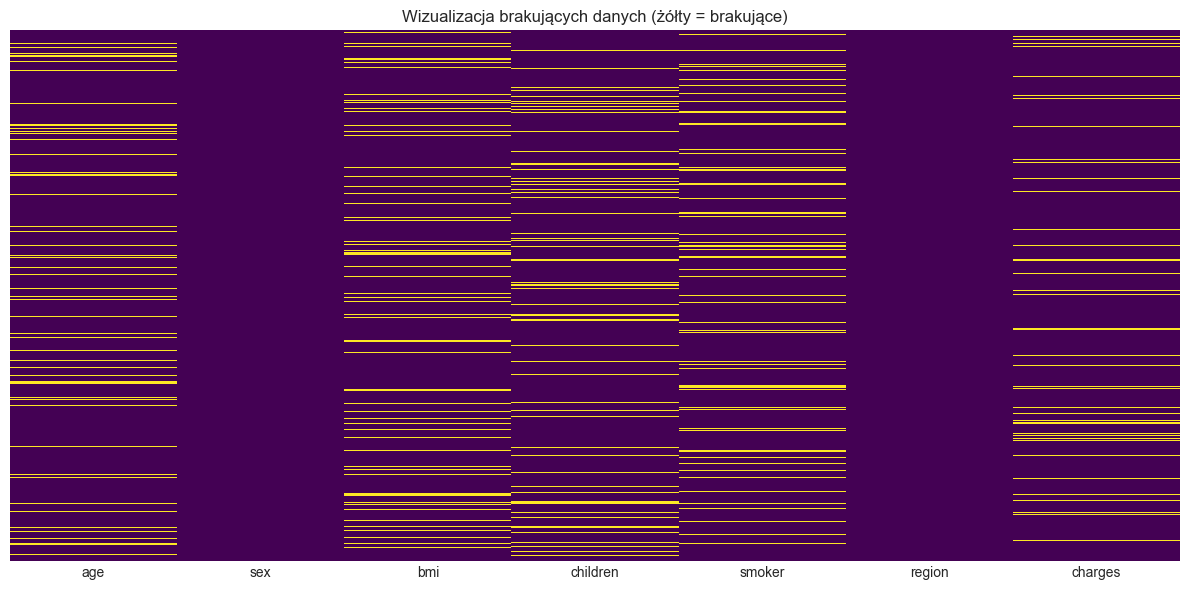

In [11]:
print("\nProcentowy udział brakujących wartości:")
missing_percent_new = (df_with_missing.isnull().sum() / len(df_with_missing)) * 100
print(missing_percent_new.round(2))

# Wizualizacja brakujących danych
plt.figure(figsize=(12, 6))
sns.heatmap(df_with_missing.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Wizualizacja brakujących danych (żółty = brakujące)')
plt.tight_layout()
plt.savefig('missing_data_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Ekstrakcja cech


In [12]:
# Przed ekstrakcją - przygotowanie DataFrame bez brakujących danych
df_for_extraction = df.copy()

In [13]:
# Cecha 1: Kategoria wieku
df_for_extraction['age_category'] = pd.cut(df_for_extraction['age'],
                                            bins=[0, 25, 40, 60, 100],
                                            labels=['young', 'adult', 'middle_aged', 'senior'])
print("\nCecha 'age_category' - kategorie wiekowe:")
print(df_for_extraction['age_category'].value_counts())


Cecha 'age_category' - kategorie wiekowe:
age_category
middle_aged    546
adult          395
young          306
senior          91
Name: count, dtype: int64


In [14]:
# Cecha 2: Kategoria BMI
df_for_extraction['bmi_category'] = pd.cut(df_for_extraction['bmi'],
                                            bins=[0, 18.5, 25, 30, 100],
                                            labels=['underweight', 'normal', 'overweight', 'obese'])
print("\nCecha 'bmi_category' - kategorie BMI:")
print(df_for_extraction['bmi_category'].value_counts())


Cecha 'bmi_category' - kategorie BMI:
bmi_category
obese          705
overweight     386
normal         226
underweight     21
Name: count, dtype: int64


In [15]:
# Cecha 3: Profil ryzyka (połączenie smoker + bmi_category)
df_for_extraction['risk_profile'] = df_for_extraction.apply(
    lambda row: 'high_risk' if row['smoker'] == 'yes' and row['bmi'] > 30
    else 'medium_risk' if row['smoker'] == 'yes' or row['bmi'] > 30
    else 'low_risk', axis=1
)
print("\nCecha 'risk_profile' - profil ryzyka:")
print(df_for_extraction['risk_profile'].value_counts())


Cecha 'risk_profile' - profil ryzyka:
risk_profile
medium_risk    691
low_risk       503
high_risk      144
Name: count, dtype: int64


In [16]:
# Cecha 4: Family size indicator
df_for_extraction['has_children'] = (df_for_extraction['children'] > 0).astype(int)
print("\nCecha 'has_children' - czy ma dzieci:")
print(df_for_extraction['has_children'].value_counts())


Cecha 'has_children' - czy ma dzieci:
has_children
1    764
0    574
Name: count, dtype: int64


In [17]:
# Cecha 5: Health score (syntetyczna cecha łącząca wiele informacji)
# Niższy score = lepsze zdrowie
df_for_extraction['health_score'] = (
    (df_for_extraction['bmi'] - 25).clip(lower=0) * 0.5 +  # BMI powyżej normy
    (df_for_extraction['smoker'] == 'yes').astype(int) * 20 +  # Palenie
    (df_for_extraction['age'] / 100) * 10  # Wiek
)
print("\nCecha 'health_score' - syntetyczny wskaźnik zdrowia:")
print(df_for_extraction['health_score'].describe())


Cecha 'health_score' - syntetyczny wskaźnik zdrowia:
count    1338.000000
mean       11.104062
std         8.651466
min         1.800000
25%         5.203125
50%         7.805000
75%        12.510000
max        36.605000
Name: health_score, dtype: float64


In [18]:
# Cecha 6: Cost per age unit (charges/age)
df_for_extraction['cost_per_age'] = df_for_extraction['charges'] / df_for_extraction['age']
print("\nCecha 'cost_per_age' - koszt na rok życia:")
print(df_for_extraction['cost_per_age'].describe())


Cecha 'cost_per_age' - koszt na rok życia:
count    1338.000000
mean      352.882780
std       372.178067
min        62.326328
25%       150.741382
50%       193.659687
75%       452.067436
max      2155.149200
Name: cost_per_age, dtype: float64


### Analiza korelacji między cechami

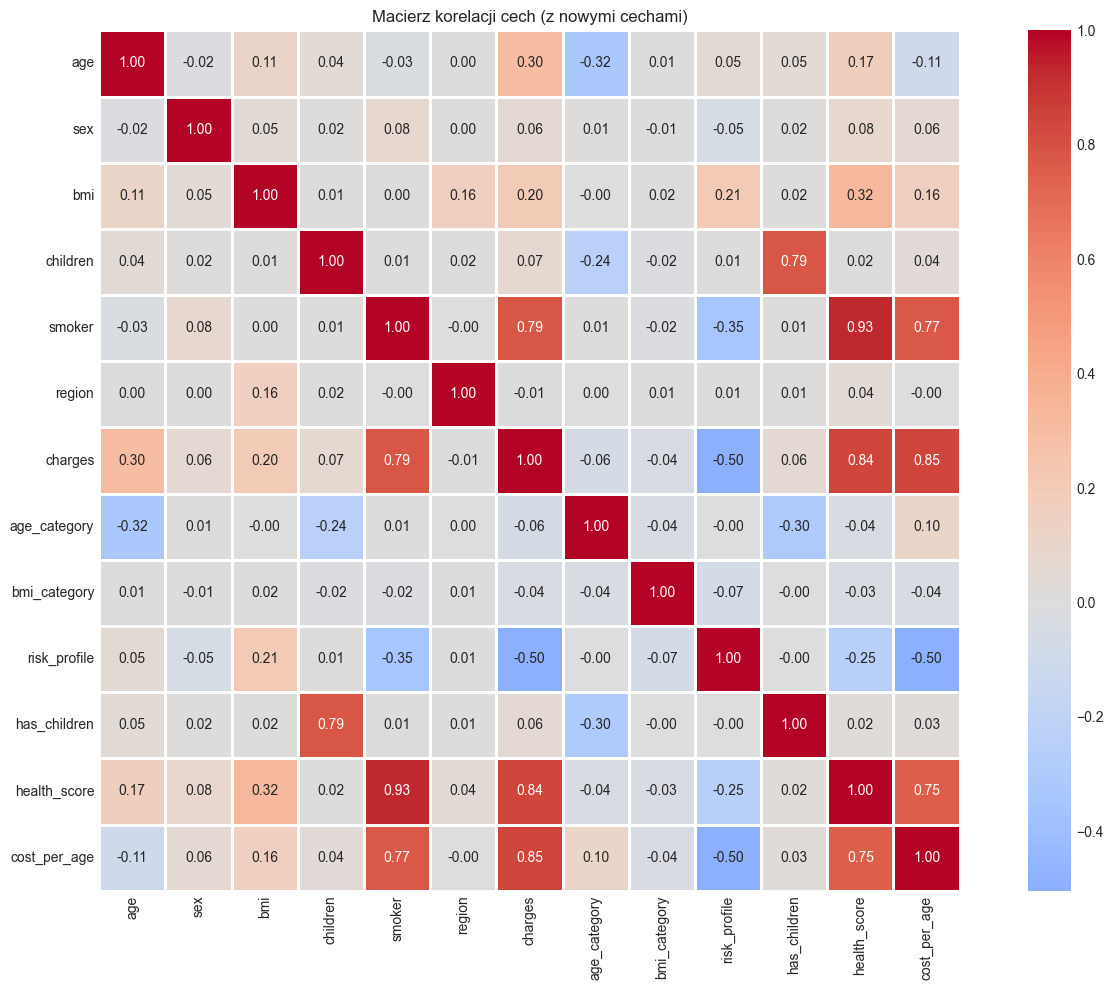


Najsilniejsze korelacje z 'charges':
charges         1.000000
cost_per_age    0.845777
health_score    0.843404
smoker          0.787251
age             0.299008
bmi             0.198341
children        0.067998
has_children    0.064760
sex             0.057292
region         -0.006208
Name: charges, dtype: float64


In [19]:
# Kodowanie zmiennych kategorycznych dla analizy korelacji
df_corr = df_for_extraction.copy()
le = LabelEncoder()
for col in ['sex', 'smoker', 'region', 'age_category', 'bmi_category', 'risk_profile']:
    if col in df_corr.columns:
        df_corr[col] = le.fit_transform(df_corr[col].astype(str))

# Macierz korelacji
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns
correlation_matrix = df_corr[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Macierz korelacji cech (z nowymi cechami)')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNajsilniejsze korelacje z 'charges':")
charges_corr = correlation_matrix['charges'].sort_values(ascending=False)
print(charges_corr.head(10))

## 5. Uzupełnianie brakujących danych — różne metody


In [20]:
df_method1 = df_with_missing.copy()  # Metoda trudniejsza: KNN
df_method2 = df_with_missing.copy()  # Metoda łatwiejsza 1: Średnia/Mediana
df_method3 = df_with_missing.copy()  # Metoda łatwiejsza 2: Regresja liniowa

### 5.1 Metoda 1 — K-Nearest Neighbors (KNN)

In [21]:
print("\nAlgorytm KNN wykorzystuje k najbliższych sąsiadów do uzupełnienia wartości.")
print("Jest to metoda zaawansowana, która uwzględnia relacje między cechami.")

# Przygotowanie danych dla KNN - kodowanie zmiennych kategorycznych
df_knn = df_method1.copy()
le_sex = LabelEncoder()
le_smoker = LabelEncoder()
le_region = LabelEncoder()

df_knn['sex_encoded'] = le_sex.fit_transform(df_knn['sex'])
df_knn['region_encoded'] = le_region.fit_transform(df_knn['region'])

# Uzupełnianie smoker oddzielnie (kategoryczna)
df_knn['smoker_temp'] = df_knn['smoker'].copy()
smoker_mode = df_knn['smoker'].mode()[0]
df_knn['smoker'].fillna(smoker_mode, inplace=True)
df_knn['smoker_encoded'] = le_smoker.fit_transform(df_knn['smoker'])

# KNN Imputer dla zmiennych numerycznych
features_for_knn = ['age', 'sex_encoded', 'bmi', 'children', 'smoker_encoded',
                    'region_encoded', 'charges']
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

df_knn[features_for_knn] = knn_imputer.fit_transform(df_knn[features_for_knn])

# Przeniesienie uzupełnionych wartości do głównego DataFrame
df_method1['age'] = df_knn['age']
df_method1['bmi'] = df_knn['bmi']
df_method1['children'] = df_knn['children'].round()
df_method1['charges'] = df_knn['charges']

# Dekodowanie smoker z powrotem na yes/no
df_method1['smoker'] = le_smoker.inverse_transform(df_knn['smoker_encoded'].astype(int))

print("\nUzupełnienie zakończone. Sprawdzenie brakujących wartości:")
print(df_method1.isnull().sum())


Algorytm KNN wykorzystuje k najbliższych sąsiadów do uzupełnienia wartości.
Jest to metoda zaawansowana, która uwzględnia relacje między cechami.

Uzupełnienie zakończone. Sprawdzenie brakujących wartości:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


### 5.2 Metoda 2 — Średnia/Mediana/Najczęstsza wartość
Wrażliwość średniej na wartości odstające można ograniczyć stosując medianę.

In [22]:
print("\nProsta metoda statystyczna:")
print("- Średnia dla zmiennych normalnie rozłożonych")
print("- Mediana dla zmiennych z wartościami odstającymi")
print("- Najczęstsza wartość dla zmiennych kategorycznych")

# Age - mediana (może mieć wartości odstające)
age_median = df_method2['age'].median()
df_method2['age'].fillna(age_median, inplace=True)
print(f"\nAge uzupełniono medianą: {age_median:.2f}")

# BMI - średnia (zazwyczaj rozkład normalny)
bmi_mean = df_method2['bmi'].mean()
df_method2['bmi'].fillna(bmi_mean, inplace=True)
print(f"BMI uzupełniono średnią: {bmi_mean:.2f}")

# Children - mediana (dyskretna)
children_median = df_method2['children'].median()
df_method2['children'].fillna(children_median, inplace=True)
print(f"Children uzupełniono medianą: {children_median:.0f}")

# Charges - mediana (ma wartości odstające)
charges_median = df_method2['charges'].median()
df_method2['charges'].fillna(charges_median, inplace=True)
print(f"Charges uzupełniono medianą: {charges_median:.2f}")

# Smoker - najczęstsza wartość
smoker_mode = df_method2['smoker'].mode()[0]
df_method2['smoker'].fillna(smoker_mode, inplace=True)
print(f"Smoker uzupełniono najczęstszą wartością: {smoker_mode}")

print("\nUzupełnienie zakończone. Sprawdzenie brakujących wartości:")
print(df_method2.isnull().sum())


Prosta metoda statystyczna:
- Średnia dla zmiennych normalnie rozłożonych
- Mediana dla zmiennych z wartościami odstającymi
- Najczęstsza wartość dla zmiennych kategorycznych

Age uzupełniono medianą: 39.00
BMI uzupełniono średnią: 30.63
Children uzupełniono medianą: 1
Charges uzupełniono medianą: 9301.89
Smoker uzupełniono najczęstszą wartością: no

Uzupełnienie zakończone. Sprawdzenie brakujących wartości:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


### 5.3 Metoda 3 — regresja liniowa

In [23]:
print("\nMetoda wykorzystuje regresję liniową do przewidywania brakujących wartości.")
print("Model uczy się na kompletnych danych i przewiduje wartości dla niekompletnych.")

def impute_with_regression(df, target_col, feature_cols):
    """Uzupełnia brakujące wartości używając regresji liniowej"""
    df_temp = df.copy()

    # Kodowanie zmiennych kategorycznych jeśli są w feature_cols
    encoders = {}
    for col in feature_cols:
        if df_temp[col].dtype == 'object':
            le = LabelEncoder()
            # Najpierw uzupełniamy brakujące wartości najczęstszą wartością
            df_temp[col] = df_temp[col].fillna(df_temp[col].mode()[0])
            df_temp[col + '_encoded'] = le.fit_transform(df_temp[col].astype(str))
            encoders[col] = le
            # Zastępujemy oryginalną kolumnę zakodowaną
            feature_cols_updated = [col + '_encoded' if c == col else c for c in feature_cols]
            feature_cols = feature_cols_updated

    # Podział na dane z wartościami i bez
    train_data = df_temp[df_temp[target_col].notna()]
    predict_data = df_temp[df_temp[target_col].isna()]

    if len(predict_data) == 0:
        return df[target_col]

    # Usuwamy wiersze z brakującymi wartościami w feature_cols dla zbioru treningowego
    train_data_clean = train_data.dropna(subset=feature_cols)

    if len(train_data_clean) == 0:
        # Jeśli nie ma kompletnych danych, użyj mediany/średniej
        if df[target_col].dtype in ['float64', 'int64']:
            return df[target_col].fillna(df[target_col].median())
        else:
            return df[target_col].fillna(df[target_col].mode()[0])

    # Trening modelu
    X_train = train_data_clean[feature_cols]
    y_train = train_data_clean[target_col]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Przewidywanie - tylko dla wierszy z kompletnymi danymi w features
    X_predict = predict_data[feature_cols]
    # Usuwamy wiersze z NaN w features
    X_predict_clean = X_predict.dropna()

    if len(X_predict_clean) > 0:
        predictions = model.predict(X_predict_clean)

        # Uzupełnienie
        result = df[target_col].copy()
        result[X_predict_clean.index] = predictions
    else:
        result = df[target_col].copy()

    return result

# Uzupełnienie w odpowiedniej kolejności - najpierw zmienne niezależne, potem zależne

# 1. Najpierw uzupełniamy smoker (najczęstsza wartość - prosta metoda)
print("Uzupełnianie 'smoker' najczęstszą wartością...")
smoker_mode = df_method3['smoker'].mode()[0]
df_method3['smoker'].fillna(smoker_mode, inplace=True)

# 2. Uzupełnienie children (mało zależności od charges)
print("Uzupełnianie 'children' za pomocą regresji...")
df_method3['children'] = impute_with_regression(
    df_method3, 'children', ['age', 'sex', 'bmi', 'smoker', 'region']
)
df_method3['children'] = df_method3['children'].round().clip(lower=0)
# Uzupełnienie pozostałych (jeśli jakieś zostały) medianą
df_method3['children'].fillna(df_method3['children'].median(), inplace=True)

# 3. Uzupełnienie bmi
print("Uzupełnianie 'bmi' za pomocą regresji...")
df_method3['bmi'] = impute_with_regression(
    df_method3, 'bmi', ['age', 'sex', 'children', 'smoker', 'region']
)
# Uzupełnienie pozostałych (jeśli jakieś zostały) średnią
df_method3['bmi'].fillna(df_method3['bmi'].mean(), inplace=True)

# 4. Uzupełnienie age
print("Uzupełnianie 'age' za pomocą regresji...")
df_method3['age'] = impute_with_regression(
    df_method3, 'age', ['sex', 'bmi', 'children', 'smoker', 'region']
)
# Uzupełnienie pozostałych (jeśli jakieś zostały) medianą
df_method3['age'].fillna(df_method3['age'].median(), inplace=True)

# 5. Uzupełnienie charges (na końcu, bo zależy od wszystkich innych)
print("Uzupełnianie 'charges' za pomocą regresji...")
df_method3['charges'] = impute_with_regression(
    df_method3, 'charges', ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
)
# Uzupełnienie pozostałych (jeśli jakieś zostały) medianą
df_method3['charges'].fillna(df_method3['charges'].median(), inplace=True)

print("\nUzupełnienie zakończone. Sprawdzenie brakujących wartości:")
print(df_method3.isnull().sum())


Metoda wykorzystuje regresję liniową do przewidywania brakujących wartości.
Model uczy się na kompletnych danych i przewiduje wartości dla niekompletnych.
Uzupełnianie 'smoker' najczęstszą wartością...
Uzupełnianie 'children' za pomocą regresji...
Uzupełnianie 'bmi' za pomocą regresji...
Uzupełnianie 'age' za pomocą regresji...
Uzupełnianie 'charges' za pomocą regresji...

Uzupełnienie zakończone. Sprawdzenie brakujących wartości:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


## 6️. Porównanie metod uzupełniania danych


--------------------------------------------------------------------------------
Porównanie dla zmiennej: age
--------------------------------------------------------------------------------
Metoda                         Średnia         Mediana         Std            
--------------------------------------------------------------------------------
Oryginalne dane                39.21           39.00           14.05          
KNN                            38.95           39.00           13.63          
Średnia/Mediana                39.19           39.00           13.36          
Regresja                       39.26           39.32           13.37          

--------------------------------------------------------------------------------
Porównanie dla zmiennej: bmi
--------------------------------------------------------------------------------
Metoda                         Średnia         Mediana         Std            
-------------------------------------------------------------

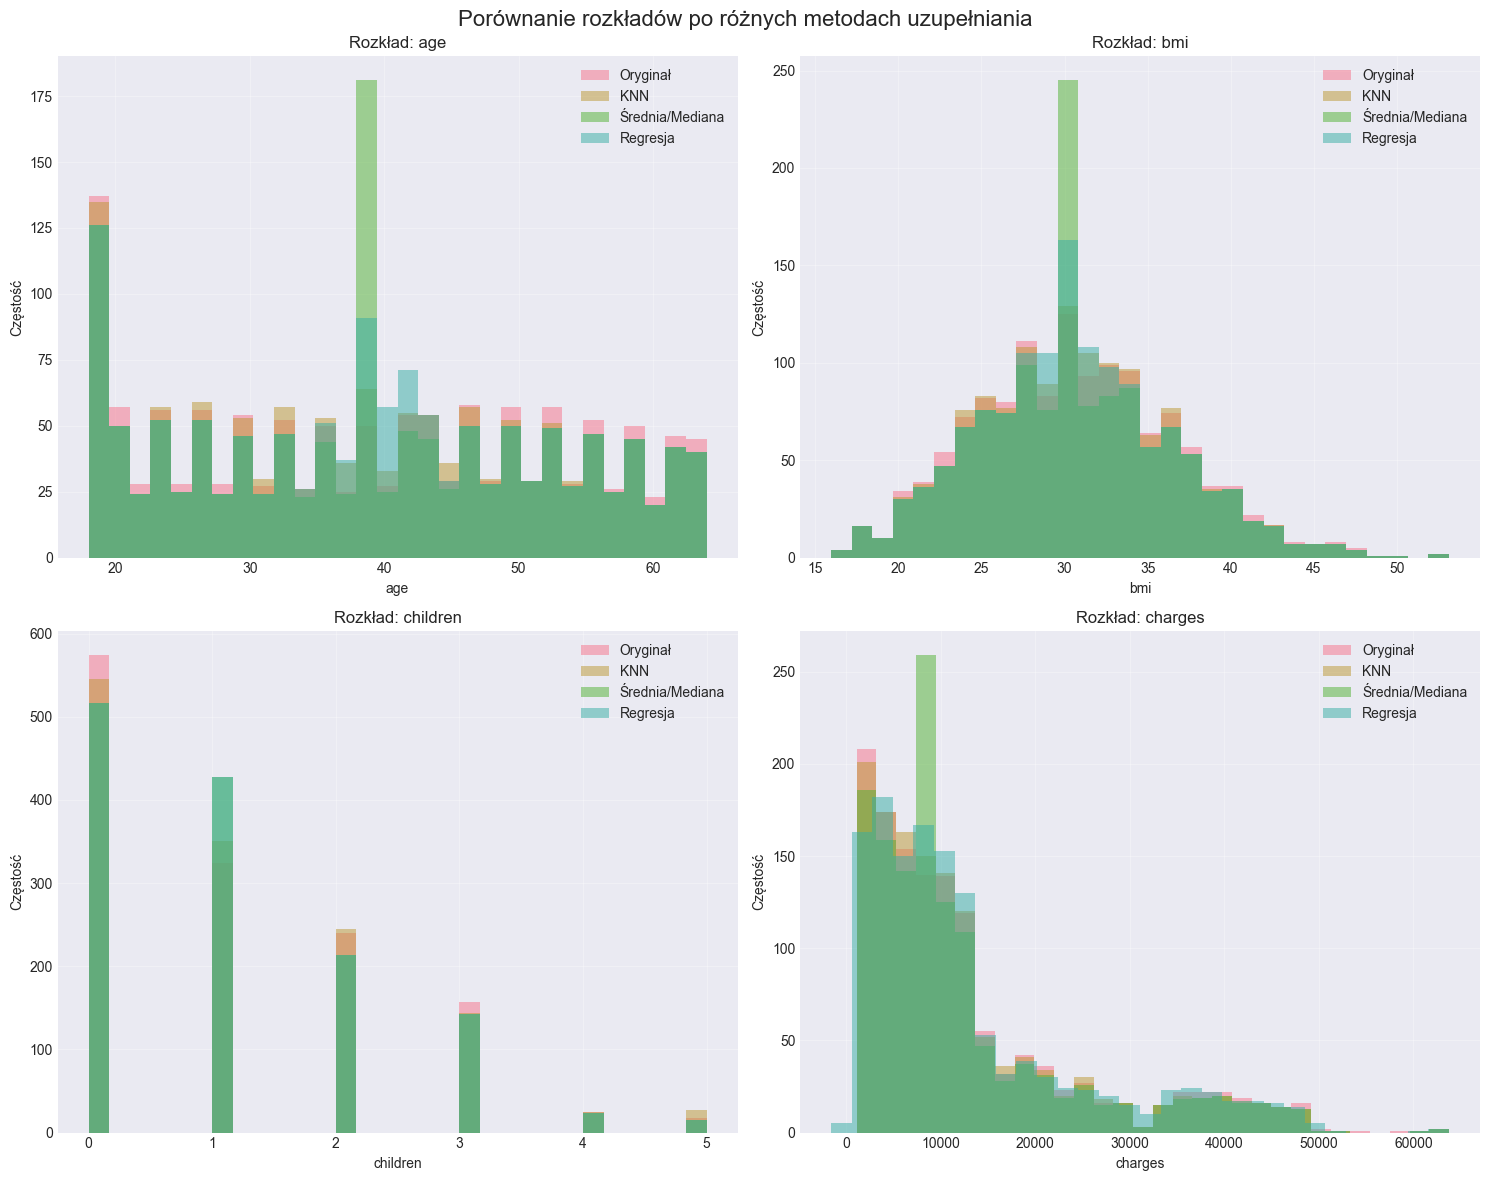

In [24]:
# Porównanie statystyk dla kluczowych zmiennych
comparison_vars = ['age', 'bmi', 'children', 'charges']

for var in comparison_vars:
    print(f"\n{'-'*80}")
    print(f"Porównanie dla zmiennej: {var}")
    print(f"{'-'*80}")
    print(f"{'Metoda':<30} {'Średnia':<15} {'Mediana':<15} {'Std':<15}")
    print(f"{'-'*80}")
    print(f"{'Oryginalne dane':<30} {df[var].mean():<15.2f} {df[var].median():<15.2f} {df[var].std():<15.2f}")
    print(f"{'KNN':<30} {df_method1[var].mean():<15.2f} {df_method1[var].median():<15.2f} {df_method1[var].std():<15.2f}")
    print(f"{'Średnia/Mediana':<30} {df_method2[var].mean():<15.2f} {df_method2[var].median():<15.2f} {df_method2[var].std():<15.2f}")
    print(f"{'Regresja':<30} {df_method3[var].mean():<15.2f} {df_method3[var].median():<15.2f} {df_method3[var].std():<15.2f}")

# Wizualizacja porównawcza
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Porównanie rozkładów po różnych metodach uzupełniania', fontsize=16)

for idx, var in enumerate(comparison_vars):
    ax = axes[idx//2, idx%2]

    ax.hist(df[var], alpha=0.5, label='Oryginał', bins=30)
    ax.hist(df_method1[var], alpha=0.5, label='KNN', bins=30)
    ax.hist(df_method2[var], alpha=0.5, label='Średnia/Mediana', bins=30)
    ax.hist(df_method3[var], alpha=0.5, label='Regresja', bins=30)

    ax.set_xlabel(var)
    ax.set_ylabel('Częstość')
    ax.set_title(f'Rozkład: {var}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Analiza danych odstających


--------------------------------------------------------------------------------
Metoda standaryzacji (|z-score| > 3):
--------------------------------------------------------------------------------

age: 0 wartości odstających

bmi: 4 wartości odstających
  Zakres wartości odstających: [49.06, 53.13]

children: 27 wartości odstających
  Zakres wartości odstających: [5.00, 5.00]

charges: 12 wartości odstających
  Zakres wartości odstających: [47896.79, 63770.43]


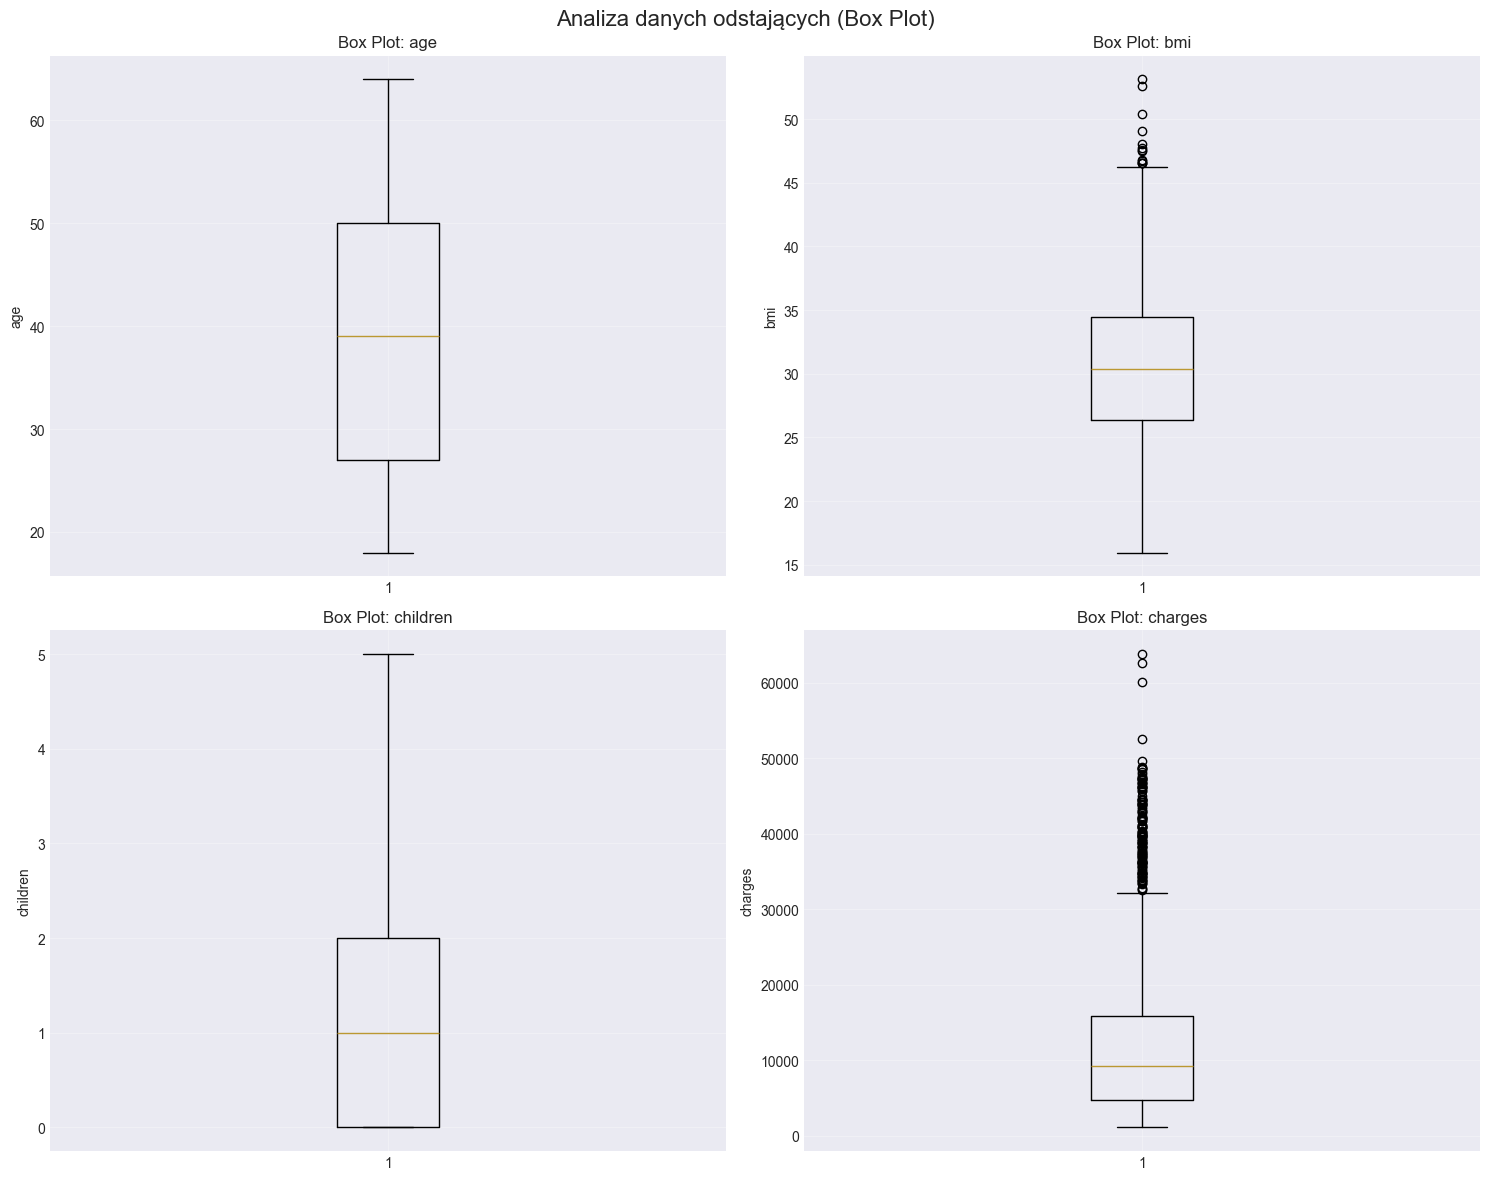


--------------------------------------------------------------------------------
Metoda IQR (Interquartile Range):
--------------------------------------------------------------------------------

age:
  Q1: 27.00, Q3: 50.00, IQR: 23.00
  Granice: [-7.50, 84.50]
  Liczba outliers: 0

bmi:
  Q1: 26.40, Q3: 34.42, IQR: 8.02
  Granice: [14.37, 46.45]
  Liczba outliers: 13

children:
  Q1: 0.00, Q3: 2.00, IQR: 2.00
  Granice: [-3.00, 5.00]
  Liczba outliers: 0

charges:
  Q1: 4803.72, Q3: 15820.02, IQR: 11016.30
  Granice: [-11720.73, 32344.47]
  Liczba outliers: 139


In [25]:
# Używamy danych po metodzie KNN jako przykład
df_clean = df_method1.copy()

# Standaryzacja dla wykrywania outliers
scaler = StandardScaler()
numeric_columns = ['age', 'bmi', 'children', 'charges']

df_scaled = df_clean.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df_clean[numeric_columns])

print("\n" + "-" * 80)
print("Metoda standaryzacji (|z-score| > 3):")
print("-" * 80)

for col in numeric_columns:
    outliers = df_scaled[np.abs(df_scaled[col]) > 3]
    print(f"\n{col}: {len(outliers)} wartości odstających")
    if len(outliers) > 0:
        print(f"  Zakres wartości odstających: [{df_clean.loc[outliers.index, col].min():.2f}, "
              f"{df_clean.loc[outliers.index, col].max():.2f}]")

# Box plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analiza danych odstających (Box Plot)', fontsize=16)

for idx, col in enumerate(numeric_columns):
    ax = axes[idx//2, idx%2]
    ax.boxplot(df_clean[col], vert=True)
    ax.set_ylabel(col)
    ax.set_title(f'Box Plot: {col}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outliers_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Metoda IQR (Interquartile Range)
print("\n" + "-" * 80)
print("Metoda IQR (Interquartile Range):")
print("-" * 80)

for col in numeric_columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]

    print(f"\n{col}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Granice: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Liczba outliers: {len(outliers)}")

## Eksport danych

In [26]:
print("\n" + "=" * 80)
print("7. PODSUMOWANIE I EKSPORT DANYCH")
print("=" * 80)

# Zapisanie przetworzonych danych
df_method1.to_csv('insurance_cleaned_knn.csv', index=False)
df_method2.to_csv('insurance_cleaned_mean_median.csv', index=False)
df_method3.to_csv('insurance_cleaned_regression.csv', index=False)
df_for_extraction.to_csv('insurance_with_features.csv', index=False)

print("\nZapisano przetworzone zbiory danych:")
print("- insurance_cleaned_knn.csv (metoda KNN)")
print("- insurance_cleaned_mean_median.csv (metoda średnia/mediana)")
print("- insurance_cleaned_regression.csv (metoda regresji)")
print("- insurance_with_features.csv (z dodatkowymi cechami)")


7. PODSUMOWANIE I EKSPORT DANYCH

Zapisano przetworzone zbiory danych:
- insurance_cleaned_knn.csv (metoda KNN)
- insurance_cleaned_mean_median.csv (metoda średnia/mediana)
- insurance_cleaned_regression.csv (metoda regresji)
- insurance_with_features.csv (z dodatkowymi cechami)


In [27]:
print(f"""
Oryginalny zbiór zawiera {df.shape[0]} rekordów i {df.shape[1]} kolumn.

Kluczowe obserwacje:
• Zbiór jest KOMPLETNY - brak naturalnie występujących braków danych
• Wszystkie wartości są w realistycznych przedziałach
• Rozkład wieku: {df['age'].min():.0f}-{df['age'].max():.0f} lat (średnia: {df['age'].mean():.1f})
• Rozkład BMI: {df['bmi'].min():.1f}-{df['bmi'].max():.1f} (średnia: {df['bmi'].mean():.1f})
• Kosztów leczenia: ${df['charges'].min():.2f}-${df['charges'].max():.2f} (mediana: ${df['charges'].median():.2f})
• Palaczy: {(df['smoker']=='yes').sum()} ({(df['smoker']=='yes').sum()/len(df)*100:.1f}%)
""")

print("\n" + "-" * 80)
print("8.2. PORÓWNANIE METOD UZUPEŁNIANIA")
print("-" * 80)

print("""
METODA 1 - KNN (K-Nearest Neighbors):
✓ ZALETY:
  • Uwzględnia relacje między cechami
  • Nie zakłada liniowej zależności
  • Dobrze radzi sobie z nieliniowymi wzorcami
  • Zachowuje naturalną wariancję danych

✗ WADY:
  • Wrażliwa na wielowymiarowość (curse of dimensionality)
  • Wymaga skalowania danych
  • Obliczeniowo kosztowna dla dużych zbiorów
  • Wymaga kodowania zmiennych kategorycznych

METODA 2 - Średnia/Mediana/Najczęstsza wartość:
✓ ZALETY:
  • Bardzo prosta i szybka
  • Intuicyjna i łatwa do wyjaśnienia
  • Nie wymaga treningu modelu
  • Stabilna i przewidywalna

✗ WADY:
  • Zmniejsza wariancję danych (wszystkie braki → jedna wartość)
  • Nie uwzględnia relacji między cechami
  • Może wprowadzać bias w rozkładzie
  • Gorsze wyniki dla skorelowanych zmiennych

METODA 3 - Regresja liniowa:
✓ ZALETY:
  • Uwzględnia zależności liniowe między zmiennymi
  • Lepiej zachowuje korelacje niż średnia/mediana
  • Przewiduje wartości na podstawie kontekstu
  • Zachowuje większą wariancję niż prosta imputacja

✗ WADY:
  • Zakłada liniowe zależności (może być nieadekwatne)
  • Wymaga określonej kolejności uzupełniania
  • Może generować nierealistyczne wartości
  • Wrażliwa na outliers w danych treningowych
""")


Oryginalny zbiór zawiera 1338 rekordów i 7 kolumn.

Kluczowe obserwacje:
• Zbiór jest KOMPLETNY - brak naturalnie występujących braków danych
• Wszystkie wartości są w realistycznych przedziałach
• Rozkład wieku: 18-64 lat (średnia: 39.2)
• Rozkład BMI: 16.0-53.1 (średnia: 30.7)
• Kosztów leczenia: $1121.87-$63770.43 (mediana: $9382.03)
• Palaczy: 274 (20.5%)


--------------------------------------------------------------------------------
8.2. PORÓWNANIE METOD UZUPEŁNIANIA
--------------------------------------------------------------------------------

METODA 1 - KNN (K-Nearest Neighbors):
✓ ZALETY:
  • Uwzględnia relacje między cechami
  • Nie zakłada liniowej zależności
  • Dobrze radzi sobie z nieliniowymi wzorcami
  • Zachowuje naturalną wariancję danych

✗ WADY:
  • Wrażliwa na wielowymiarowość (curse of dimensionality)
  • Wymaga skalowania danych
  • Obliczeniowo kosztowna dla dużych zbiorów
  • Wymaga kodowania zmiennych kategorycznych

METODA 2 - Średnia/Mediana/Najczęstsz

### Część 2

In [28]:
import pandas as pd

data = pd.read_csv("data/insurance_cleaned_knn.csv")

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900000,0.0,yes,southwest,16884.9240
1,18.0,male,33.770000,0.0,no,southeast,1725.5523
2,28.0,male,33.000000,3.0,no,southeast,4449.4620
3,33.0,male,32.046667,0.0,no,northwest,12406.0841
4,32.0,male,28.880000,0.0,no,northwest,3866.8552


In [30]:
print("Liczebność danych w kolumnie 'sex':")
print(data['sex'].value_counts())

print("\nLiczebność danych w kolumnie 'smoker':")
print(data['smoker'].value_counts())

unique_regions = pd.read_csv("data/insurance_cleaned_knn.csv")['region'].unique()
print("Unikalne regiony w danych:", unique_regions)

print("\nPodsumowanie danych liczbowych:")
data.describe()

Liczebność danych w kolumnie 'sex':
sex
male      676
female    662
Name: count, dtype: int64

Liczebność danych w kolumnie 'smoker':
smoker
no     1091
yes     247
Name: count, dtype: int64
Unikalne regiony w danych: ['southwest' 'southeast' 'northwest' 'northeast']

Podsumowanie danych liczbowych:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,38.945735,30.632518,1.127803,12921.882121
std,13.631773,5.957355,1.224026,11632.331143
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.410000,0.000000,4803.718837
50%,38.960377,30.400000,1.000000,9273.638800
75%,50.000000,34.400000,2.000000,15813.482798
max,64.000000,53.130000,5.000000,63770.428010


In [50]:
data['sex'] = data['sex'].map({'female': 0, 'male': 1})
data['smoker'] = data['smoker'].map({'no': 0, 'yes': 1})
data = pd.get_dummies(data, columns=['region'], drop_first=True)
data.to_csv("data/insurance_converted.csv", index=False)

### Analiza zbioru w oparciu o funkcje Pandas


Kolumna sex zawierająca wartości tekstowe (female, male) jest zamieniana na wartości liczbowe: female na 0, a male na 1.

Kolumna smoker zawierająca wartości tekstowe (no, yes) jest zamieniana na wartości liczbowe: no na 0, a yes na 1.

Kolumna region zawierająca wartości tekstowe (southwest, southeast, northwest, northeast) jest zamieniana na kilka kolumn binarnych (0/1) dla każdego regionu, z wyjątkiem pierwszego (northeast), który jest pomijany.  Po zakodowaniu o pominięciu pierwszej kolumny (northeast), pozostałe trzy kolumny w pełni opisują dane. Brakująca kategoria (northeast) jest traktowana jako domyślna, gdy wszystkie inne kolumny mają wartość 0.


In [33]:
data.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19.0,0,27.900000,0.0,1,16884.9240,False,False,True
1,18.0,1,33.770000,0.0,0,1725.5523,False,True,False
2,28.0,1,33.000000,3.0,0,4449.4620,False,True,False
3,33.0,1,32.046667,0.0,0,12406.0841,True,False,False
4,32.0,1,28.880000,0.0,0,3866.8552,True,False,False


In [34]:
# Podstawowe informacje o zbiorze danych
print("Liczba rekordów:", len(data))
print("Kolumny:", list(data.columns), "\n")

Liczba rekordów: 1338
Kolumny: ['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest'] 



In [35]:
data.describe()

,age,sex,bmi,children,smoker,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,38.945735,0.505232,30.632518,1.127803,0.184604,12921.882121
std,13.631773,0.500160,5.957355,1.224026,0.388121,11632.331143
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.410000,0.000000,0.000000,4803.718837
50%,38.960377,1.000000,30.400000,1.000000,0.000000,9273.638800
75%,50.000000,1.000000,34.400000,2.000000,0.000000,15813.482798
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010


In [36]:
# Grupowanie wg cech
avg_by_smoker = data.groupby('smoker')['charges'].mean().reset_index()
avg_by_sex = data.groupby('sex')['charges'].mean().reset_index()

In [37]:
def infer_region(row):
    if 'region_northwest' in row and row['region_northwest'] == 1:
        return 'northwest'
    elif 'region_southeast' in row and row['region_southeast'] == 1:
        return 'southeast'
    elif 'region_southwest' in row and row['region_southwest'] == 1:
        return 'southwest'
    else:
        return 'northeast'


In [38]:
data['region_orig'] = data.apply(infer_region, axis=1)
avg_by_region = data.groupby('region_orig')['charges'].mean().reset_index()

In [39]:
import plotly.express as px

fig1 = px.scatter(
    data, x='bmi', y='charges', color='smoker',
    size='age', hover_data=['children', 'sex'],
    title="Zależność między BMI a Charges"
)
fig1.show()

In [40]:
fig2 = px.histogram(
    data, x='charges', nbins=10, color='smoker', barmode='overlay',
    title="Rozkład kosztów ubezpieczenia (charges)"
)

fig2.update_traces(opacity=0.6)
fig2.show()

In [41]:
fig3 = px.box(
    data, x='smoker', y='charges', color='smoker',
    title="Porównanie kosztów wg statusu palenia"
)
fig3.show()

In [42]:
fig4 = px.bar(
    avg_by_region, x='region_orig', y='charges', color='region_orig',
    title="Średnie koszty ubezpieczenia wg regionu", text='charges'
)
fig4.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig4.show()

In [43]:
fig5 = px.bar(
    data.groupby('children')['charges'].mean().reset_index(),
    x='children', y='charges', title="Średnie koszty wg liczby dzieci",
    text='charges'
)
fig5.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig5.show()

In [44]:
fig_age = px.scatter(
    data, x='age', y='charges', color='smoker', symbol='sex',
    hover_data=['bmi', 'children', 'region_orig'],
    title="Zależność między wiekiem (age) a kosztami (charges)",
    labels={'sex': 'płeć (0=female, 1=male)', 'smoker': 'palenie (0=no, 1=yes)'}
)
fig_age.show()

In [45]:
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['<20', '20–29', '30–39', '40–49', '50–59', '60–69', '70+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

avg_by_age_sex = data.groupby(['age_group', 'sex'])['charges'].mean().reset_index()
avg_by_age_sex['sex'] = avg_by_age_sex['sex'].map({0: 'female', 1: 'male'})

fig_age_sex = px.bar(
    avg_by_age_sex, x='age_group', y='charges', color='sex', barmode='group',
    title="Średnie koszty ubezpieczenia wg przedziału wieku i płci",
    text='charges'
)
fig_age_sex.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_age_sex.update_layout(xaxis_title="Przedział wieku", yaxis_title="Średnie koszty (charges)")
fig_age_sex.show()

### Zaawansowany wykres pokazujący możliwie najwięcej danych

In [46]:
data['region'] = data['region_orig']

fig = px.scatter_3d(
    data,
    x='age',
    y='bmi',
    z='charges',
    color='smoker',
    symbol='sex',
    size='charges',
    hover_data=['region', 'children', 'age', 'bmi', 'charges'],
    animation_frame='region',
    title="Analiza: wiek, BMI, płeć, palenie, region i koszty ubezpieczenia",
    color_discrete_map={'Smoker': 'crimson', 'Non-smoker': 'steelblue'}
)

fig.update_layout(
    scene=dict(
        xaxis_title='Wiek (age)',
        yaxis_title='BMI',
        zaxis_title='Koszty (charges)'
    ),
    legend_title_text='Status palenia',
    title_font_size=20,
    margin=dict(l=0, r=0, b=0, t=60)
)

fig.show()

### Wyrysowanie i analiza histogramów


In [47]:
fig_bmi = px.histogram(
    data,
    x='bmi',
    color='smoker',
    nbins=20,
    barmode='overlay',
    opacity=0.6,
    title="Rozkład BMI wg statusu palenia"
)
fig_bmi.update_layout(xaxis_title="BMI", yaxis_title="Liczba osób")
fig_bmi.show()

In [48]:
fig_children = px.histogram(
    data,
    x='children',
    color='sex',
    barmode='group',
    title="Liczba dzieci wg płci"
)
fig_children.update_layout(xaxis_title="Liczba dzieci", yaxis_title="Liczba osób")
fig_children.show()

In [49]:
fig_region = px.histogram(
    data,
    x='charges',
    color='smoker',
    facet_col='region',
    nbins=20,
    opacity=0.6,
    title="Rozkład kosztów (charges) wg regionu i statusu palenia"
)
fig_region.update_layout(xaxis_title="Charges", yaxis_title="Liczba osób")
fig_region.show()